In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/churn-in-telecoms-dataset/bigml_59c28831336c6604c800002a.csv


Підключення до дататсету

In [2]:
df = pd.read_csv('../input/churn-in-telecoms-dataset/bigml_59c28831336c6604c800002a.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Задача класифікації, цільова змінна - churn.

Зробимо препроцессінг даних. Видалимо з датасету дані про номер телефону, перекодуємо категоріальні змінні.

In [3]:
df = df.drop(columns='phone number', axis=1)
df['international plan']=df['international plan'].map({'yes':1,'no':0})
df['voice mail plan']=df['voice mail plan'].map({'yes':1,'no':0})
dummies = pd.Series(df['state']).str.get_dummies()
df = pd.concat([dummies,df], axis=1)
df['area code']=df['area code'].astype('str')
dummies = pd.Series(df['area code']).str.get_dummies()
df = pd.concat([dummies,df], axis=1)
df = df.drop(columns=['state','area code'], axis=1)
df['churn']=df['churn'].astype('int64')
df.head()

,408,415,510,AK,AL,AR,AZ,CA,CO,CT,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,0,1,0,0,0,0,0,0,0,0,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,0,1,0,0,0,0,0,0,0,0,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,0,1,0,0,0,0,0,0,0,0,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,1,0,0,0,0,0,0,0,0,0,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,0,1,0,0,0,0,0,0,0,0,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


Розіб'ємо датасет на навчальну та валідаційну вибірку

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [5]:
X = df.drop('churn', axis=1) 
y = df['churn'] 
scaler = StandardScaler()
X_st = scaler.fit_transform(X)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_st, y, test_size=0.25, random_state=12)

**Дерева рішень**

Обучимо модель класифікації, яка будує дерева рішень та перевіримо, як вона працює:

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [7]:
tree = DecisionTreeClassifier(max_depth=3, random_state=11310)
tree.fit(X_train, Y_train)
Y_pred = tree.predict(X_valid)
print(accuracy_score(Y_valid, Y_pred))

0.9016786570743405


Тепер налаштуємо гіперпараметри дерева:

max_depth

In [8]:
from sklearn.model_selection import GridSearchCV

tree_params = {'max_depth': np.arange(2, 45),}

tree_gridMD = GridSearchCV(tree, tree_params, cv=5, scoring='accuracy')
tree_gridMD.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=3, random_state=11310),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44])},
             scoring='accuracy')

In [9]:
print(tree_gridMD.best_score_)
print(tree_gridMD.best_estimator_)

0.9347767535070141
DecisionTreeClassifier(max_depth=6, random_state=11310)


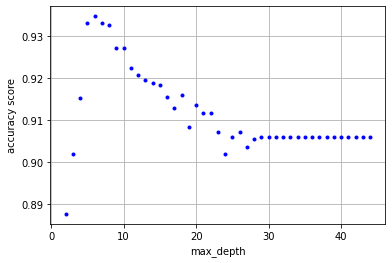

In [10]:
import matplotlib.pyplot as plt
res = pd.DataFrame(tree_gridMD.cv_results_)
plt.plot(res['param_max_depth'], res['mean_test_score'],'b.')
plt.ylabel('accuracy score')
plt.xlabel('max_depth')
plt.grid()
plt.show()


min_samples_leaf

In [11]:
tree_params = {'max_depth': [6],
               'min_samples_leaf': np.arange(2, 15),
              }
tree_gridMSL = GridSearchCV(tree, tree_params, cv=5, scoring='accuracy')
tree_gridMSL.fit(X_train, Y_train)
print(tree_gridMSL.best_score_)
print(tree_gridMSL.best_estimator_)

0.936375150300601
DecisionTreeClassifier(max_depth=6, min_samples_leaf=2, random_state=11310)


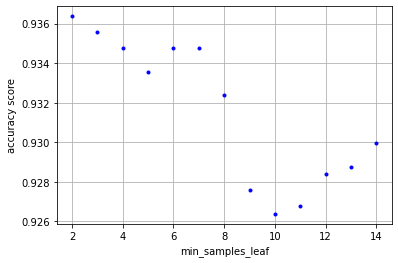

In [12]:
res = pd.DataFrame(tree_gridMSL.cv_results_)
plt.plot(res['param_min_samples_leaf'], res['mean_test_score'],'b.')
plt.ylabel('accuracy score')
plt.xlabel('min_samples_leaf')
plt.grid()
plt.show()

min_samples_split

In [13]:
tree_params = {'max_depth': [6],
               'min_samples_leaf': [2],
               'min_samples_split': np.arange(2,31)
              }
tree_gridMSS = GridSearchCV(tree, tree_params, cv=5, scoring='accuracy')
tree_gridMSS.fit(X_train, Y_train)
print(tree_gridMSS.best_score_)
print(tree_gridMSS.best_estimator_)

0.937976753507014
DecisionTreeClassifier(max_depth=6, min_samples_leaf=2, min_samples_split=7,
                       random_state=11310)


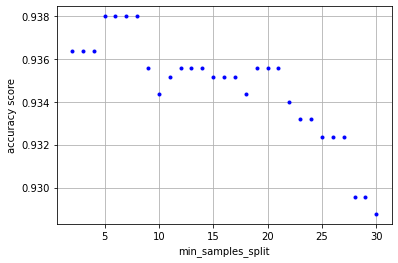

In [14]:
res = pd.DataFrame(tree_gridMSS.cv_results_)
plt.plot(res['param_min_samples_split'], res['mean_test_score'],'b.')
plt.ylabel('accuracy score')
plt.xlabel('min_samples_split')
plt.grid()
plt.show()


max_features

In [15]:
tree_params = {'max_depth': [6],
               'min_samples_leaf': [2],
               'min_samples_split': [7],
               'max_features':np.arange(2,106)
              }
tree_gridMF = GridSearchCV(tree, tree_params, cv=5, scoring='accuracy')
tree_gridMF.fit(X_train, Y_train)
print(tree_gridMF.best_score_)
print(tree_gridMF.best_estimator_)

0.9431783567134268
DecisionTreeClassifier(max_depth=6, max_features=57, min_samples_leaf=2,
                       min_samples_split=7, random_state=11310)


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
170 fits failed out of a total of 520.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
170 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/opt/conda/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 308, in fit
    raise ValueError("max_features must be in (0, n_features]")
ValueError: max_features must be in (0

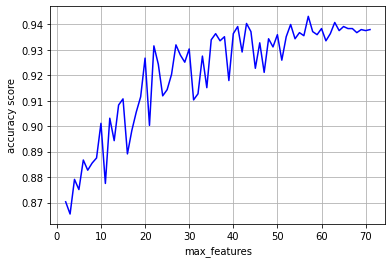

In [16]:
res = pd.DataFrame(tree_gridMF.cv_results_)
plt.plot(res['param_max_features'], res['mean_test_score'],'b')
plt.ylabel('accuracy score')
plt.xlabel('max_features')
plt.grid()
plt.show()

Підібравши оптимальні параметри, навчимо обрану модель та перевіримо, як вона працює:

In [17]:
tree = tree_gridMF.best_estimator_
tree.fit(X_train, Y_train)
Y_pred = tree.predict(X_valid)
print(accuracy_score(Y_valid, Y_pred))

0.9436450839328537


Візуалізуємо дерево за допомогою графу:

In [18]:
from sklearn.tree import export_graphviz

export_graphviz(tree, out_file='tree.dot', feature_names = X.columns)
print(open('tree.dot').read())

digraph Tree {
node [shape=box, fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label="total day charge <= 1.555\ngini = 0.248\nsamples = 2499\nvalue = [2137, 362]"] ;
1 [label="customer service calls <= 1.473\ngini = 0.201\nsamples = 2337\nvalue = [2072, 265]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="international plan <= 1.363\ngini = 0.144\nsamples = 2155\nvalue = [1987, 168]"] ;
1 -> 2 ;
3 [label="total day charge <= 0.798\ngini = 0.091\nsamples = 1960\nvalue = [1866, 94]"] ;
2 -> 3 ;
4 [label="total eve minutes <= 2.53\ngini = 0.054\nsamples = 1684\nvalue = [1637, 47]"] ;
3 -> 4 ;
5 [label="number vmail messages <= 2.587\ngini = 0.052\nsamples = 1678\nvalue = [1633, 45]"] ;
4 -> 5 ;
6 [label="gini = 0.05\nsamples = 1666\nvalue = [1623, 43]"] ;
5 -> 6 ;
7 [label="gini = 0.278\nsamples = 12\nvalue = [10, 2]"] ;
5 -> 7 ;
8 [label="gini = 0.444\nsamples = 6\nvalue = [4, 2]"] ;
4 -> 8 ;
9 [label="total eve minutes <= 0.962\ngini = 0.283\nsampl

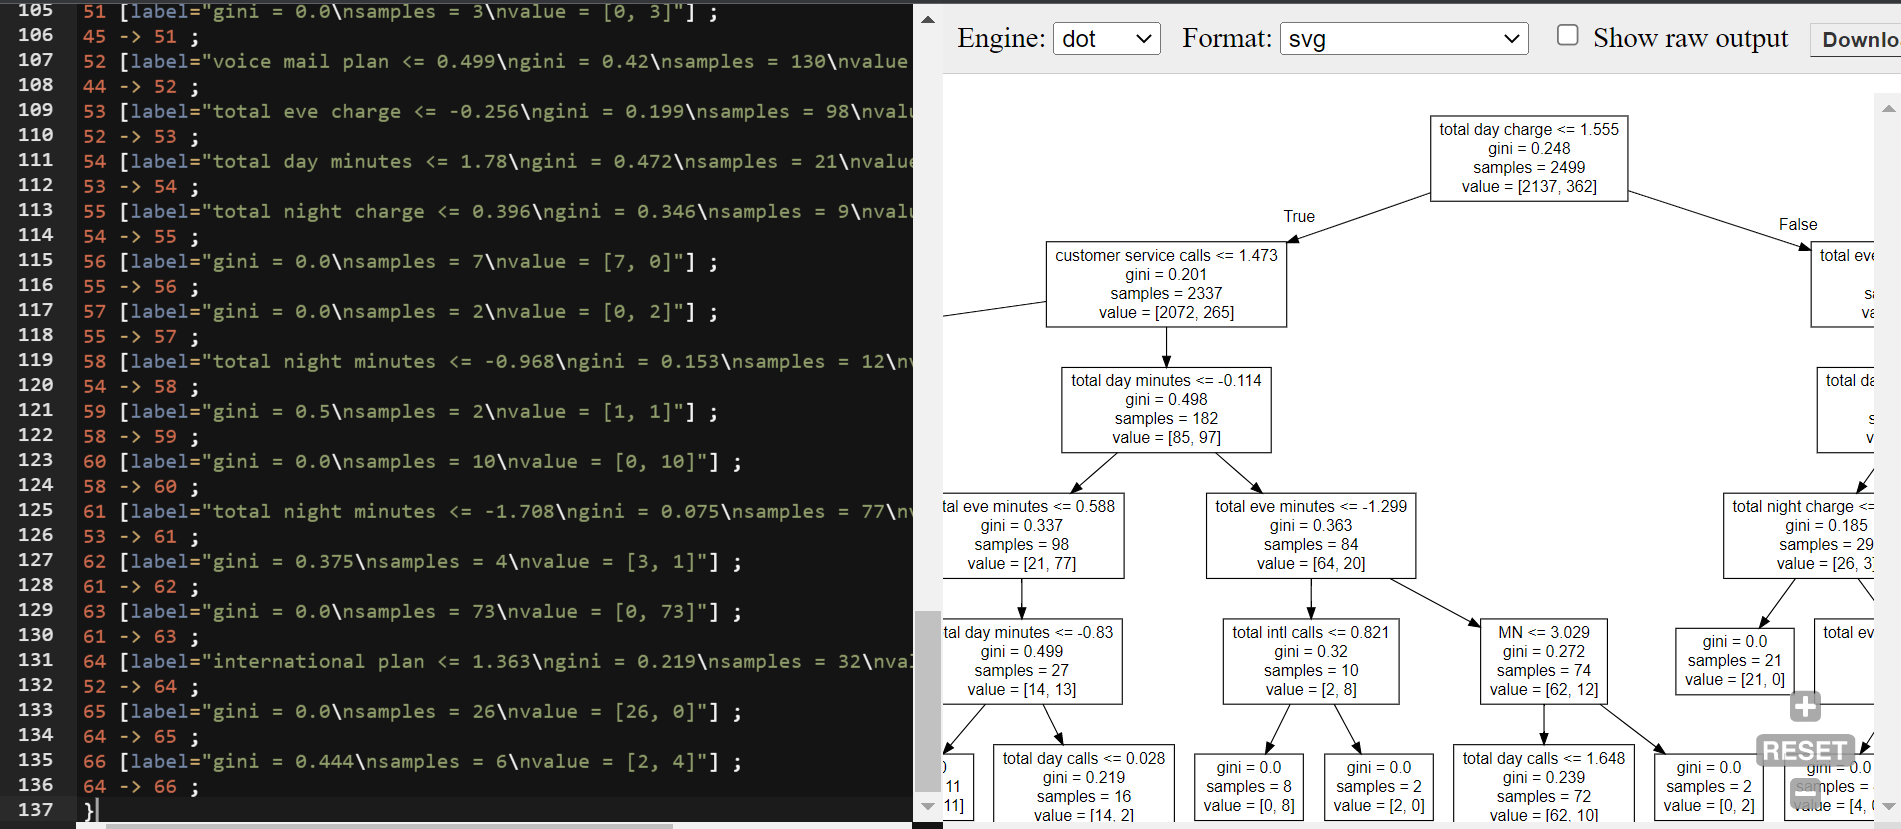

[Посилання на svg-файл](https://drive.google.com/file/d/187BxzKu1E_D45c6f_TWAJilByEH23yGb/view?usp=share_link)

Оцінимо корисність цієї моделі. Візуалізуємо топ-10 найкорисніших ознак за допомогою стопчатої діаграми

Feature ranking:
1 total day charge 0.19354006172955954
2 customer service calls 0.1553702263462471
3 total eve minutes 0.12644644686842652
4 total intl charge 0.1025960168206525
5 international plan 0.09685558294493672
6 total day minutes 0.09406126638181898
7 total intl calls 0.08841680282921435
8 voice mail plan 0.08337596772778254
9 total night minutes 0.01140175167528323
10 total night charge 0.010598764016927201


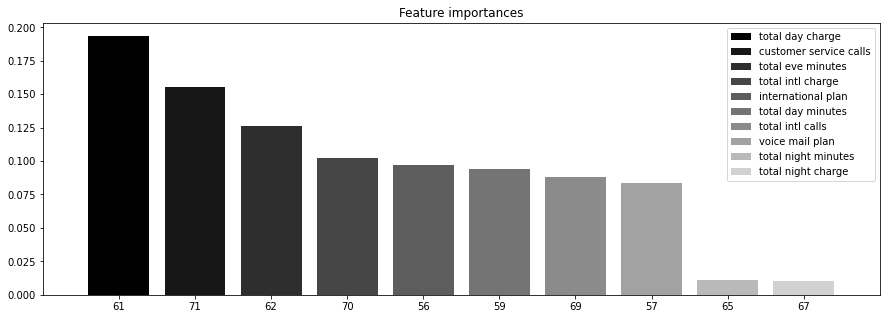

In [19]:
features = {'f'+str(i+1):name for (i, name) in zip(range(len(X.columns)), X.columns)}
                                        
importances = tree.feature_importances_

indices = np.argsort(importances)[::-1]

num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

print("Feature ranking:")

for f in range(num_to_plot):
    print(f+1, features["f"+str(feature_indices[f])], importances[indices[f]])

plt.figure(figsize=(15,5))
plt.title("Feature importances")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
               color=([str(i/float(num_to_plot+1)) for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)]) for i in feature_indices])

**Випадковий ліс**

Аналогічно підключемо модель класивікації, що використовує випадковий ліс, та проведемо налаштування гіперпараметрів

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_valid)
print(accuracy_score(Y_valid, Y_pred))

0.9460431654676259


n_estimators

In [21]:
rf_params = {'n_estimators':np.arange(25,200)
              }
rf_NE = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy')
rf_NE.fit(X_train, Y_train)

print(rf_NE.best_score_)
print(rf_NE.best_params_)

0.9323767535070141
{'n_estimators': 165}


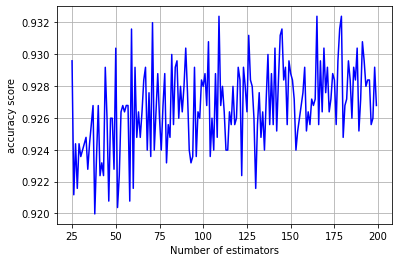

In [22]:
res = pd.DataFrame(rf_NE.cv_results_)
plt.plot(res['param_n_estimators'], res['mean_test_score'],'b')
plt.ylabel('accuracy score')
plt.xlabel('Number of estimators')
plt.grid()
plt.show()

max_depth

In [23]:
rf_params = {'n_estimators':[108],
             'max_depth':np.arange(2,25)
              }
rf_MD = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy')
rf_MD.fit(X_train, Y_train)

print(rf_MD.best_score_)
print(rf_MD.best_params_)

0.9307783567134269
{'max_depth': 22, 'n_estimators': 108}


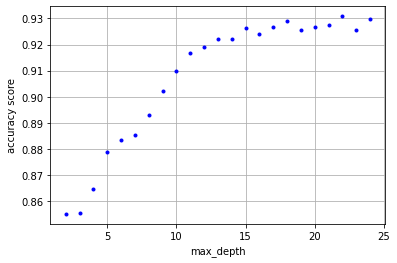

In [24]:
res = pd.DataFrame(rf_MD.cv_results_)
plt.plot(res['param_max_depth'], res['mean_test_score'],'b.')
plt.ylabel('accuracy score')
plt.xlabel('max_depth')
plt.grid()
plt.show()

min_samples_split

In [25]:
rf_params = {'n_estimators':[108],
             'max_depth':[19],
             'min_samples_split':np.arange(2,25)
              }
rf_MSS = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy')
rf_MSS.fit(X_train, Y_train)

print(rf_MSS.best_score_)
print(rf_MSS.best_params_)

0.9319775551102204
{'max_depth': 19, 'min_samples_split': 4, 'n_estimators': 108}


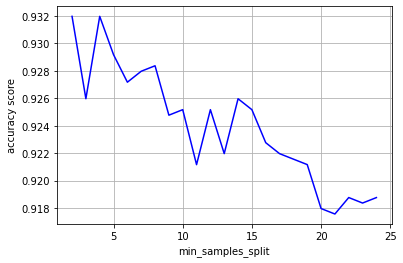

In [26]:
res = pd.DataFrame(rf_MSS.cv_results_)
plt.plot(res['param_min_samples_split'], res['mean_test_score'],'b')
plt.ylabel('accuracy score')
plt.xlabel('min_samples_split')
plt.grid()
plt.show()

min_samples_leaf

In [27]:
rf_params = {'n_estimators':[108],
             'max_depth':[19],
             'min_samples_split':[7],
             'min_samples_leaf':np.arange(2,25)
              }
rf_MSL = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy')
rf_MSL.fit(X_train, Y_train)

print(rf_MSL.best_score_)
print(rf_MSL.best_params_)

0.9183703406813628
{'max_depth': 19, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 108}


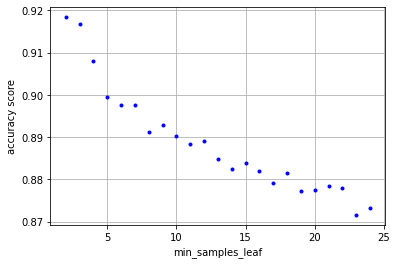

In [28]:
res = pd.DataFrame(rf_MSL.cv_results_)
plt.plot(res['param_min_samples_leaf'], res['mean_test_score'],'b.')
plt.ylabel('accuracy score')
plt.xlabel('min_samples_leaf')
plt.grid()
plt.show()

max_features

In [29]:
rf_params = {'n_estimators':[108],
             'max_depth':[19],
             'min_samples_split':[7],
             'min_samples_leaf':[2],
             'max_features':np.arange(25,106)
              }
rf_MF = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy')
rf_MF.fit(X_train, Y_train)

print(rf_MF.best_score_)
print(rf_MF.best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
170 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
170 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/p

0.9507799599198398
{'max_depth': 19, 'max_features': 60, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 108}


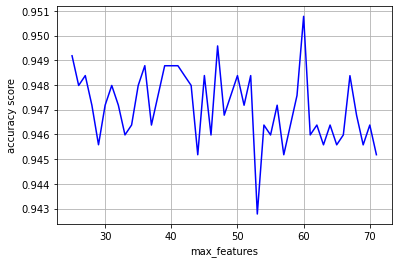

In [30]:
res = pd.DataFrame(rf_MF.cv_results_)
plt.plot(res['param_max_features'], res['mean_test_score'],'b')
plt.ylabel('accuracy score')
plt.xlabel('max_features')
plt.grid()
plt.show()

Застосуємо оптимальну модель

In [31]:
rf = RandomForestClassifier(max_depth=19, max_features=48, min_samples_leaf=2, min_samples_split=7, n_estimators=108)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_valid)
print(accuracy_score(Y_valid, Y_pred))

0.9568345323741008


Feature ranking:
1 total day charge 0.1452001557465684
2 customer service calls 0.13442697878352639
3 total day minutes 0.12195827076043585
4 international plan 0.08547028895481007
5 total intl calls 0.08156066689547097
6 total eve minutes 0.07233751554590809
7 total eve charge 0.06774373896403511
8 total intl charge 0.046186959903581286
9 total intl minutes 0.040951538138477864
10 number vmail messages 0.03619392455353657


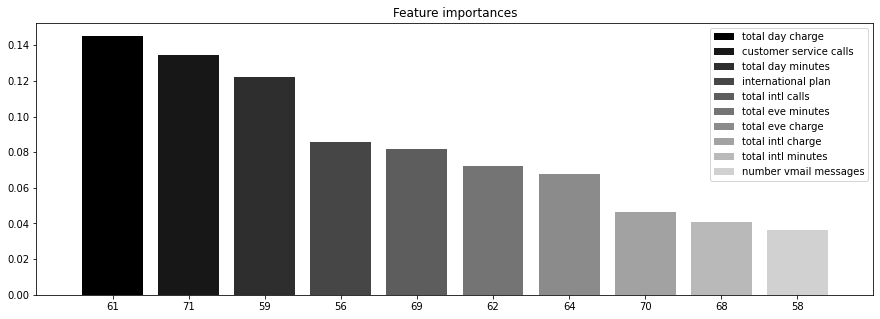

In [32]:
features = {'f'+str(i+1):name for (i, name) in zip(range(len(X.columns)), X.columns)}
                                        
importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]

num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

print("Feature ranking:")
for f in range(num_to_plot):
    print(f+1, features["f"+str(feature_indices[f])], importances[indices[f]])

plt.figure(figsize=(15,5))
plt.title("Feature importances")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
               color=([str(i/float(num_to_plot+1)) for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)]) for i in feature_indices])

**Висновки:**

Точність метричних методів: 0.854916067146283

Точність оптимальної моделі дерева рішень: 0.9436450839328537


Точність оптимальної моделі випадкового лісу: 0.9568345323741008


Модель випадкового лісу дає найкращий результат, але її недоліком є тривалість підбору гіперпараметрів. Набори визначних фіч для дерев та випадкового лісу співпадають, але відрізняється їх послідовність в топі.